# Correlating well log pairs: Complex Dynamic Time Warping with boundary constraints

## Introduction to dynamic time warping

In [1]:
# Data manipulation and analysis
import os
import gc
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from pyCoreRelator import (
    load_log_data,
    load_core_age_constraints,
    load_pickeddepth_ages_from_csv,
    run_multi_parameter_analysis,
    calculate_quality_comparison_t_statistics,
    plot_quality_comparison_t_statistics
)

<hr>

### Define basic parameters

### Define core pairs

In [2]:
# Define core names as variables for easy reference
# CORE_A = "M9907-31PC"
# CORE_A = "M9907-23PC"
CORE_A = "M9907-25PC"
# CORE_A = "M9907-12PC"
# CORE_A = "M9907-11PC"
# CORE_A = "RR0207-56PC" 

CORE_B = "M9907-23PC"
# CORE_B = "M9907-11PC"
# CORE_B = "M9907-25PC"
# CORE_B = "RR0207-56PC" 

#### Log data paths and column name structure

In [3]:
# Define log columns to extract
# LOG_COLUMNS = ['hiresMS', 'CT', 'Lumin']  # Choose which logs to include
LOG_COLUMNS = ['hiresMS']  # Choose which logs to include

# Define depth column
DEPTH_COLUMN = 'SB_DEPTH_cm'

# For multidimensional DTW, choose DTW method:
pca_for_dependent_dtw=False

# Define directory paths
mother_dir = '/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/'

# Define paths for Core A
core_a_log_paths = {
    'hiresMS': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_hiresMS_MLfilled.csv',
    'CT': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_CT_MLfilled.csv',
    'Lumin': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_RGB_MLfilled.csv',
    'R': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_RGB_MLfilled.csv',
    'G': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_RGB_MLfilled.csv',
    'B': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_RGB_MLfilled.csv',
    'Den_gm/cc': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_MST_MLfilled.csv'
}

# Define paths for Core B
core_b_log_paths = {
    'hiresMS': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_hiresMS_MLfilled.csv',
    'CT': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_CT_MLfilled.csv',
    'Lumin': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_RGB_MLfilled.csv',
    'R': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_RGB_MLfilled.csv',
    'G': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_RGB_MLfilled.csv',
    'B': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_RGB_MLfilled.csv',
    'Den_gm/cc': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_MST_MLfilled.csv'
}

# Define column mapping for alternative column names
column_alternatives = {
    'hiresMS': ['MS'],
    'CT': ['CT_value'],
    'R': ['R', 'red', 'Red'],
    'G': ['G', 'green', 'Green'],
    'B': ['B', 'blue', 'Blue'],
    'Lumin': ['luminance', 'Luminance'],
    'Den_gm/cc': ['Density', 'density']
}

<hr>

### Load log data

In [4]:
# Load data for Core A
log_a, md_a, _, _, _ = load_log_data(
    core_a_log_paths,
    log_columns=LOG_COLUMNS,
    depth_column=DEPTH_COLUMN,
    normalize=True,
    column_alternatives=column_alternatives
)

# Load data for Core B
log_b, md_b, _, _, _ = load_log_data(
    core_b_log_paths,
    log_columns=LOG_COLUMNS,
    depth_column=DEPTH_COLUMN,
    normalize=True,
    column_alternatives=column_alternatives
)

### Load picked depth boundaries

In [5]:
%matplotlib inline

# Define paths to the CSV files
pickeddepth_a_csv = f'pickeddepth/{CORE_A}_pickeddepth.csv'
pickeddepth_b_csv = f'pickeddepth/{CORE_B}_pickeddepth.csv'

# Load picked depths and extract category 1 depths
if os.path.exists(pickeddepth_a_csv):
    picked_data_a = pd.read_csv(pickeddepth_a_csv)
    all_depths_a_cat1 = picked_data_a[picked_data_a['category'] == 1]['picked_depths_cm'].values.astype('float32')
    intepreted_bed_a_cat1 = picked_data_a[picked_data_a['category'] == 1]['interpreted_bed'].fillna('').values.astype('str')
else:
    print(f"Warning: {pickeddepth_a_csv} not found. Using empty array for all_depths_a_cat1.")
    all_depths_a_cat1 = np.array([]).astype('float32')
    intepreted_bed_a_cat1 = np.array([]).astype('str').fillna('')

if os.path.exists(pickeddepth_b_csv):
    picked_data_b = pd.read_csv(pickeddepth_b_csv)
    all_depths_b_cat1 = picked_data_b[picked_data_b['category'] == 1]['picked_depths_cm'].values.astype('float32')
    intepreted_bed_b_cat1 = picked_data_b[picked_data_b['category'] == 1]['interpreted_bed'].fillna('').values.astype('str')
else:
    print(f"Warning: {pickeddepth_b_csv} not found. Using empty array for all_depths_b_cat1.")
    all_depths_b_cat1 = np.array([]).astype('float32')
    intepreted_bed_b_cat1 = np.array([]).astype('str').fillna('')

### Load age data

In [6]:
# Load age constraints for both cores
consider_adjacent_core = True

data_columns = {                                # Define age constraint data columns in the imported csv file   
    'age': 'calib502_agebp',                    # Calibrated radiocarbon age in years before present
    'pos_error': 'calib502_2sigma_pos',         # Positive 2-sigma uncertainty in age
    'neg_error': 'calib502_2sigma_neg',         # Negative 2-sigma uncertainty in age
    'min_depth': 'mindepth_cm',                 # Minimum depth of age constraint in cm
    'max_depth': 'maxdepth_cm',                 # Maximum depth of age constraint in cm
    'in_sequence': 'in_sequence',               # Flag indicating if constraint is in stratigraphic sequence
    'core': 'core',                             # Core identifier for the age constraint
    'interpreted_bed': 'interpreted_bed'        # Interpreted bed/layer identifier
}

# Configuration: Define the path to the age constraints csv file
age_base_path = '/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/Age constraints/Goldfinger2012'

# Load age constraints for both cores: Load the age constraints for both cores from the csv file
age_data_a = load_core_age_constraints(CORE_A, age_base_path, consider_adjacent_core, data_columns, mute_mode=True)
age_data_b = load_core_age_constraints(CORE_B, age_base_path, consider_adjacent_core, data_columns, mute_mode=True)

### Load estimated ages for each picked depth boundary from csv

In [7]:
# Load estimated boundary age data for both cores from CSV files using the imported function
cores = [CORE_A, CORE_B]
pickeddepth_ages = {}

# Define the uncertainty method: 'MonteCarlo', 'Linear', or 'Gaussian'
uncertainty_method='MonteCarlo'   

for core in cores:
    core_age_csv = f"pickeddepth_ages/{core}_pickeddepth_ages_{uncertainty_method}.csv"
    pickeddepth_ages[core] = load_pickeddepth_ages_from_csv(core_age_csv)

# Assign to individual variables for backward compatibility
if CORE_A in pickeddepth_ages:
    pickeddepth_ages_a = pickeddepth_ages[CORE_A]
if CORE_B in pickeddepth_ages:
    pickeddepth_ages_b = pickeddepth_ages[CORE_B]

Loaded 20 pickeddepth ages from M9907-25PC_pickeddepth_ages_MonteCarlo.csv
Loaded 20 pickeddepth ages from M9907-23PC_pickeddepth_ages_MonteCarlo.csv


<hr>

## Compute quality metric distribution for all stituation

In [8]:
# Cell: Multi-Parameter Distribution Analysis

test_age_constraint_removal = True  # Set to False to disable age constraint removal testing

# For multidimensional DTW, choose DTW method:
pca_for_dependent_dtw=False

# Run all parameter combinations and plot distribution curves together

# Define all parameter combinations to test
parameter_combinations = [
    # {'age_consideration': True, 'restricted_age_correlation': True, 'shortest_path_search': False},
    {'age_consideration': True, 'restricted_age_correlation': True, 'shortest_path_search': True},
    # {'age_consideration': True, 'restricted_age_correlation': False, 'shortest_path_search': False},
    # {'age_consideration': True, 'restricted_age_correlation': False, 'shortest_path_search': True},
    # {'age_consideration': False, 'restricted_age_correlation': False, 'shortest_path_search': False},
    {'age_consideration': False, 'restricted_age_correlation': False, 'shortest_path_search': True}
]

# Define all quality indices to process
target_quality_indices = ['corr_coef', 'norm_dtw']

output_csv_filenames = {}
for quality_index in target_quality_indices:
    output_csv_filenames[quality_index] = f'outputs/{CORE_A}_{CORE_B}/{"_".join(LOG_COLUMNS)}/{quality_index}_fit_params.csv'

# Define synthetic CSV filenames for consistent bin sizing
synthetic_csv_filenames = {}
for quality_index in target_quality_indices:
    synthetic_csv_filenames[quality_index] = f'outputs/synthetic_PDFs_{"_".join(LOG_COLUMNS)}_{quality_index}.csv'

# Execute the analysis function
run_multi_parameter_analysis(
    # Core data inputs
    log_a=log_a, 
    log_b=log_b, 
    md_a=md_a, 
    md_b=md_b,
    all_depths_a_cat1=all_depths_a_cat1,
    all_depths_b_cat1=all_depths_b_cat1,
    pickeddepth_ages_a=pickeddepth_ages_a,
    pickeddepth_ages_b=pickeddepth_ages_b,
    age_data_a=age_data_a,
    age_data_b=age_data_b,
    uncertainty_method=uncertainty_method,
    
    # Analysis parameters
    parameter_combinations=parameter_combinations,
    target_quality_indices=target_quality_indices,
    test_age_constraint_removal=test_age_constraint_removal,
    
    # Core identifiers
    core_a_name=CORE_A,
    core_b_name=CORE_B,
    
    # Output configuration
    output_csv_filenames=output_csv_filenames,
    
    # Optional parameter
    pca_for_dependent_dtw=pca_for_dependent_dtw,

    # Maximum number of scenarios per constraint removal layer
    max_search_per_layer= 100,

    # Number of cores used in parallel processing
    n_jobs=-1     # -1: uses all available cores
)

Running 2 parameter combinations for 2 quality indices...
Using all available CPU cores for parallel processing
Age constraint removal testing enabled:
- Core B has 5 age constraints
- Additional 30 scenarios exist
- As max_search_per_layer is defined: 100 scenarios are randomly sampled from each constraint removal layer
- ⚠️  WARNING: Due to random sampling, not every run will yield identical results
-     This just provides statistical approximation while maintaining computational feasibility

=== PHASE 1: Running original parameter combinations ===


Original parameter combinations: 100%|██████████| 2/2 [00:00<00:00, 46.79it/s]


✓ All original parameter combinations processed

=== PHASE 2: Running age constraint removal scenarios ===
- Core B has 5 age constraints
- Processing 30 additional constraint removal scenarios
max_search_per_layer is defined: randomly sampling up to 100 scenarios per layer of search
- Layer 1 constraints: 5 scenarios (all processed)
- Layer 2 constraints: 10 scenarios (all processed)
- Layer 3 constraints: 10 scenarios (all processed)
- Layer 4 constraints: 5 scenarios (all processed)


Age constraint removal scenarios: 100%|██████████| 30/30 [00:16<00:00,  1.83it/s]


✓ Phase 2 completed: All age constraint removal scenarios processed

✓ All processing completed
Sorting CSV files for consistent ordering...
✓ Sorted outputs/M9907-25PC_M9907-23PC/hiresMS/corr_coef_fit_params.csv
✓ Sorted outputs/M9907-25PC_M9907-23PC/hiresMS/norm_dtw_fit_params.csv
✓ corr_coef fit_params saved to: outputs/M9907-25PC_M9907-23PC/hiresMS/corr_coef_fit_params.csv
✓ norm_dtw fit_params saved to: outputs/M9907-25PC_M9907-23PC/hiresMS/norm_dtw_fit_params.csv


### Plotting: compare the quality metric to the null hypothesis

  Calculating statistics for norm_dtw: 100%|██████████| 32/32 [00:00<00:00, 160.79it/s]


✓ Distribution plot saved as: outputs/M9907-25PC_M9907-23PC/hiresMS/corr_coef_compare2null.png
✓ t-statistics plot saved as: outputs/M9907-25PC_M9907-23PC/hiresMS/corr_coef_compare2null_tstat.png
✓ Distribution plot saved as: outputs/M9907-25PC_M9907-23PC/hiresMS/norm_dtw_compare2null.png
✓ t-statistics plot saved as: outputs/M9907-25PC_M9907-23PC/hiresMS/norm_dtw_compare2null_tstat.png


KeyError: 'corr_coef'

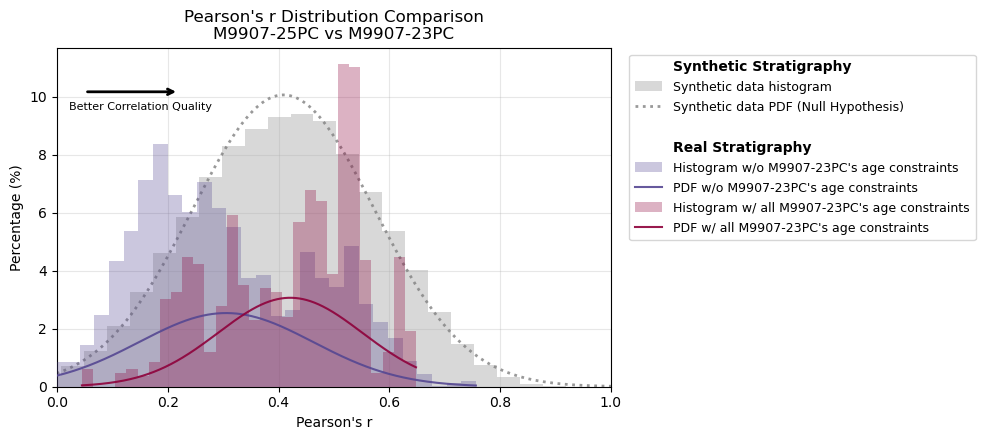

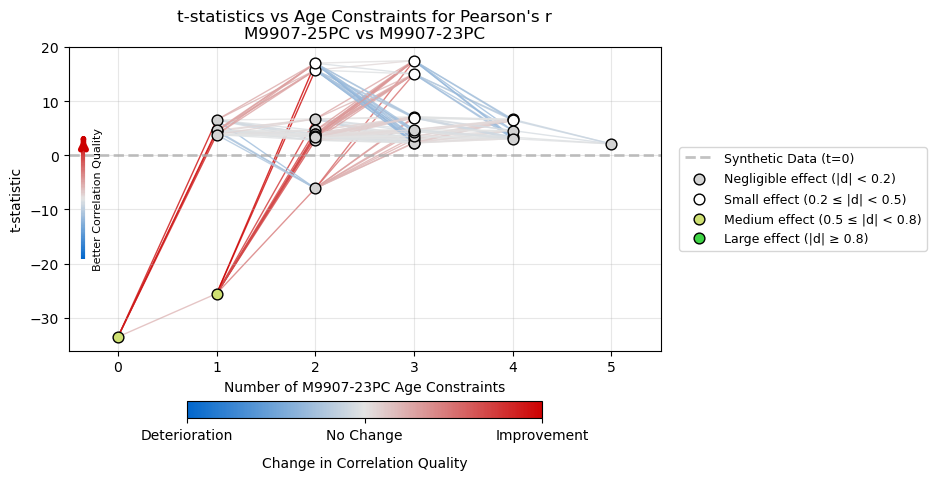

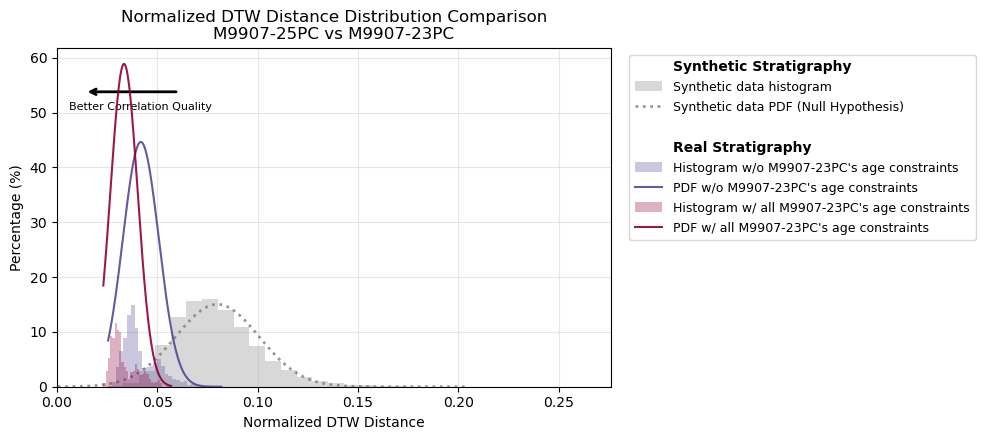

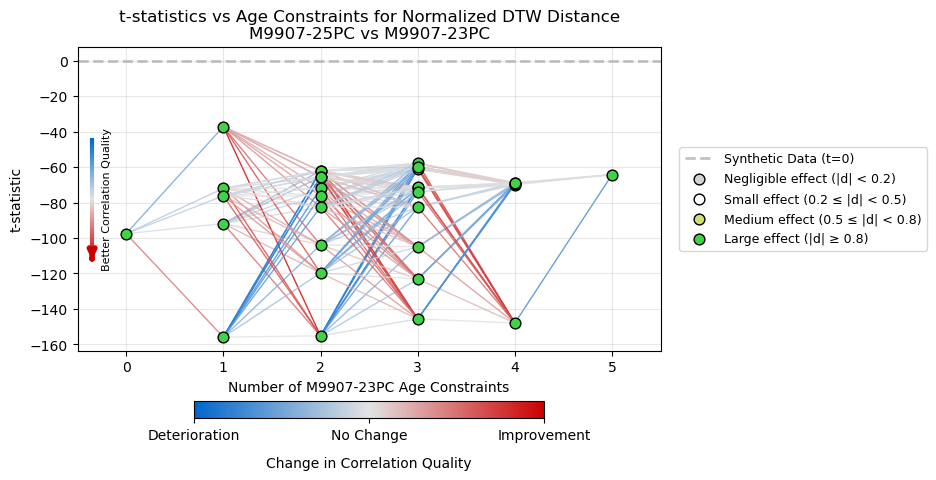

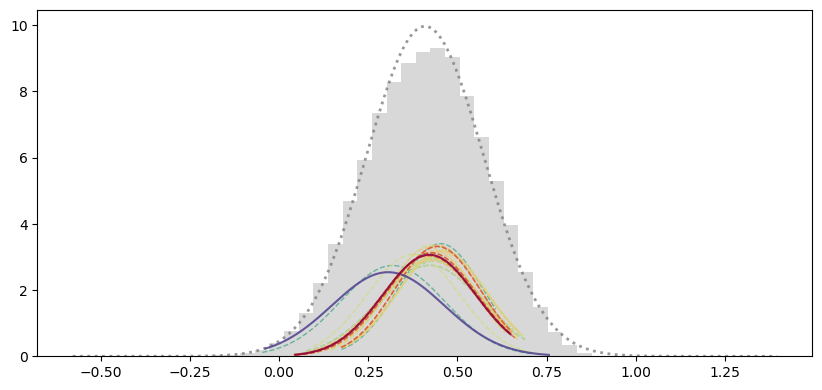

In [10]:
# Define file names outside the function
target_quality_indices = ['corr_coef', 'norm_dtw']

# Define input path for master CSV filenames
master_csv_filenames = {}
for quality_index in target_quality_indices:
    master_csv_filenames[quality_index] = f'outputs/{CORE_A}_{CORE_B}/{"_".join(LOG_COLUMNS)}/{quality_index}_fit_params.csv'

# Define input path for synthetic CSV filenames
synthetic_csv_filenames = {}
for quality_index in target_quality_indices:
    synthetic_csv_filenames[quality_index] = f'outputs/synthetic_PDFs_{"_".join(LOG_COLUMNS)}_{quality_index}.csv'

# Define output figure filenames
output_figure_filenames = {}
for quality_index in target_quality_indices:
    output_figure_filenames[quality_index] = f'outputs/{CORE_A}_{CORE_B}/{"_".join(LOG_COLUMNS)}/{quality_index}_compare2null.png'

# Define animated gifs showing progressive constraint addition
output_gif_filenames = {}
for quality_index in target_quality_indices:
    output_gif_filenames[quality_index] = f'outputs/{CORE_A}_{CORE_B}/{"_".join(LOG_COLUMNS)}/{quality_index}_compare2null.gif'
        
# Step 1: Calculate statistics (run once)
calculate_quality_comparison_t_statistics(
    target_quality_indices=target_quality_indices,
    master_csv_filenames=master_csv_filenames,
    synthetic_csv_filenames=synthetic_csv_filenames,
    CORE_A=CORE_A,
    CORE_B=CORE_B,
    mute_mode=False
)

# Step 2: Plot results
plot_quality_comparison_t_statistics(
    target_quality_indices=target_quality_indices,
    master_csv_filenames=master_csv_filenames,
    synthetic_csv_filenames=synthetic_csv_filenames,
    CORE_A=CORE_A,
    CORE_B=CORE_B,
    mute_mode=True,
    save_fig=True,
    output_figure_filenames=output_figure_filenames,
    save_gif=False, 
    max_frames = 40,
    output_gif_filenames=output_gif_filenames,
    plot_real_data_histogram=True,
    plot_age_removal_step_pdf=False
    )

plot_quality_comparison_t_statistics(
    target_quality_indices=target_quality_indices,
    master_csv_filenames=master_csv_filenames,
    synthetic_csv_filenames=synthetic_csv_filenames,
    CORE_A=CORE_A,
    CORE_B=CORE_B,
    mute_mode=True,
    save_fig=False,
    output_figure_filenames=output_figure_filenames,
    save_gif=True, 
    max_frames = 40,
    output_gif_filenames=output_gif_filenames,
    plot_real_data_histogram=False,
    plot_age_removal_step_pdf=True
    )

<hr> 

## Loop Processing

In [ ]:
# # Define all core options
# from re import T


# CORE_A_OPTIONS = ["M9907-11PC", "M9907-12PC", "M9907-23PC", "M9907-25PC", "M9907-30PC", "M9907-31PC", "RR0207-56PC"]
# CORE_B_OPTIONS = ["M9907-11PC", "M9907-23PC", "M9907-30PC"]

# # Define log columns to extract
# # LOG_COLUMNS = ['hiresMS', 'CT', 'Lumin']  # Choose which logs to include
# LOG_COLUMNS = ['hiresMS']  # Choose which logs to include
# # LOG_COLUMNS = ['CT']  # Choose which logs to include
# # LOG_COLUMNS = ['Lumin']  # Choose which logs to include

# # Define depth column
# DEPTH_COLUMN = 'SB_DEPTH_cm'

# # For multidimensional DTW, choose DTW method:
# pca_for_dependent_dtw=False

# # Define directory paths
# mother_dir = '/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/'

# # Define all quality indices to process
# target_quality_indices = ['corr_coef', 'norm_dtw', 'perc_diag']
# # target_quality_indices = ['dtw_warp_eff'] 

# # Define all parameter combinations to test
# parameter_combinations = [
#     {'age_consideration': True, 'restricted_age_correlation': True, 'shortest_path_search': True},
#     {'age_consideration': False, 'restricted_age_correlation': False, 'shortest_path_search': True}
# ]

# # Configuration
# age_base_path = '/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/Age constraints/Goldfinger2012'
# uncertainty_method='MonteCarlo'   # 'MonteCarlo', 'Linear', or 'Gaussian'
# test_age_constraint_removal = True  # Set to False to disable age constraint removal testing

# def force_cleanup():
#     """Force aggressive garbage collection and memory cleanup"""
#     plt.close('all')
#     for _ in range(3):
#         gc.collect()

# ######
# # Loop through all valid combinations of CORE_A and CORE_B
# for CORE_A in CORE_A_OPTIONS:
#     for CORE_B in CORE_B_OPTIONS:
#         # Skip if CORE_A and CORE_B are the same
#         if CORE_A == CORE_B:
#             continue
            
#         print(f"\n{'='*80}")
#         print(f"Processing core pair: {CORE_A} vs {CORE_B}")
#         print(f"{'='*80}")
        
#         try:
#             # Define paths for Core A
#             core_a_log_paths = {
#                 'hiresMS': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_hiresMS_MLfilled.csv',
#                 'CT': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_CT_MLfilled.csv',
#                 'Lumin': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_RGB_MLfilled.csv',
#                 'R': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_RGB_MLfilled.csv',
#                 'G': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_RGB_MLfilled.csv',
#                 'B': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_RGB_MLfilled.csv',
#                 'Den_gm/cc': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_MST_MLfilled.csv'
#             }

#             # Define paths for Core B
#             core_b_log_paths = {
#                 'hiresMS': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_hiresMS_MLfilled.csv',
#                 'CT': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_CT_MLfilled.csv',
#                 'Lumin': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_RGB_MLfilled.csv',
#                 'R': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_RGB_MLfilled.csv',
#                 'G': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_RGB_MLfilled.csv',
#                 'B': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_RGB_MLfilled.csv',
#                 'Den_gm/cc': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_MST_MLfilled.csv'
#             }

#             # Define column mapping for alternative column names
#             column_alternatives = {
#                 'hiresMS': ['MS'],
#                 'CT': ['CT_value'],
#                 'R': ['R', 'red', 'Red'],
#                 'G': ['G', 'green', 'Green'],
#                 'B': ['B', 'blue', 'Blue'],
#                 'Lumin': ['luminance', 'Luminance'],
#                 'Den_gm/cc': ['Density', 'density']
#             }

#             # Load data for Core A
#             log_a, md_a, _, _, _ = load_log_data(
#                 core_a_log_paths,
#                 log_columns=LOG_COLUMNS,
#                 depth_column=DEPTH_COLUMN,
#                 normalize=True,
#                 column_alternatives=column_alternatives
#             )

#             # Load data for Core B
#             log_b, md_b, _, _, _ = load_log_data(
#                 core_b_log_paths,
#                 log_columns=LOG_COLUMNS,
#                 depth_column=DEPTH_COLUMN,
#                 normalize=True,
#                 column_alternatives=column_alternatives
#             )

#             # Define paths to the CSV files
#             pickeddepth_a_csv = f'pickeddepth/{CORE_A}_pickeddepth.csv'
#             pickeddepth_b_csv = f'pickeddepth/{CORE_B}_pickeddepth.csv'

#             # Load picked depths and extract category 1 depths
#             if os.path.exists(pickeddepth_b_csv):
#                 picked_data_b = pd.read_csv(pickeddepth_b_csv)
#                 all_depths_b_cat1 = picked_data_b[picked_data_b['category'] == 1]['picked_depths_cm'].values.astype('float32')
#             else:
#                 print(f"Warning: {pickeddepth_b_csv} not found. Using empty array for all_depths_b_cat1.")
#                 all_depths_b_cat1 = np.array([]).astype('float32')

#             if os.path.exists(pickeddepth_a_csv):
#                 picked_data_a = pd.read_csv(pickeddepth_a_csv)
#                 all_depths_a_cat1 = picked_data_a[picked_data_a['category'] == 1]['picked_depths_cm'].values.astype('float32')
#             else:
#                 print(f"Warning: {pickeddepth_a_csv} not found. Using empty array for all_depths_a_cat1.")
#                 all_depths_a_cat1 = np.array([]).astype('float32')

#             # Load age constraints for both cores
#             consider_adjacent_core = True

#             data_columns = {
#                 'age': 'calib502_agebp',
#                 'pos_error': 'calib502_2sigma_pos', 
#                 'neg_error': 'calib502_2sigma_neg',
#                 'min_depth': 'mindepth_cm',
#                 'max_depth': 'maxdepth_cm',
#                 'in_sequence': 'in_sequence',
#                 'core': 'core',
#                 'interpreted_bed': 'interpreted_bed'
#             }

#             # Load age constraints for both cores
#             age_data_a = load_core_age_constraints(CORE_A, age_base_path, consider_adjacent_core, data_columns, mute_mode=True)
#             age_data_b = load_core_age_constraints(CORE_B, age_base_path, consider_adjacent_core, data_columns, mute_mode=True)

#             # Load pickeddepth ages from CSV files
#             core_a_age_csv = f"pickeddepth_ages/{CORE_A}_pickeddepth_ages_{uncertainty_method}.csv"
#             core_b_age_csv = f"pickeddepth_ages/{CORE_B}_pickeddepth_ages_{uncertainty_method}.csv"
            
#             pickeddepth_ages_a = load_pickeddepth_ages_from_csv(core_a_age_csv)
#             pickeddepth_ages_b = load_pickeddepth_ages_from_csv(core_b_age_csv)

#             # Set up output CSV filenames
#             output_csv_filenames = {}
#             for quality_index in target_quality_indices:
#                 output_csv_filenames[quality_index] = f'outputs/{CORE_A}_{CORE_B}/{"_".join(LOG_COLUMNS)}/{quality_index}_fit_params.csv'
            
#             # Execute the analysis function
#             run_multi_parameter_analysis(
#                 # Core data inputs
#                 log_a=log_a, 
#                 log_b=log_b, 
#                 md_a=md_a, 
#                 md_b=md_b,
#                 all_depths_a_cat1=all_depths_a_cat1,
#                 all_depths_b_cat1=all_depths_b_cat1,
#                 pickeddepth_ages_a=pickeddepth_ages_a,
#                 pickeddepth_ages_b=pickeddepth_ages_b,
#                 age_data_a=age_data_a,
#                 age_data_b=age_data_b,
#                 uncertainty_method=uncertainty_method,
                
#                 # Analysis parameters
#                 parameter_combinations=parameter_combinations,
#                 target_quality_indices=target_quality_indices,
#                 test_age_constraint_removal=test_age_constraint_removal,
                
#                 # Core identifiers
#                 core_a_name=CORE_A,
#                 core_b_name=CORE_B,
                
#                 # Output configuration
#                 output_csv_filenames=output_csv_filenames,
                
#                 # Optional parameter
#                 pca_for_dependent_dtw=pca_for_dependent_dtw,

#                 # Maximum number of scenarios per constraint removal layer
#                 max_search_per_layer= 100,

#                 # Number of cores used in parallel processing
#                 n_jobs=-1     # -1: uses all available cores
#             )

#             # Define input path for master CSV filenames
#             master_csv_filenames = {}
#             for quality_index in target_quality_indices:
#                 master_csv_filenames[quality_index] = f'outputs/{CORE_A}_{CORE_B}/{"_".join(LOG_COLUMNS)}/{quality_index}_fit_params.csv'

#             # Define input path for synthetic CSV filenames
#             synthetic_csv_filenames = {}
#             for quality_index in target_quality_indices:
#                 synthetic_csv_filenames[quality_index] = f'outputs/synthetic_PDFs_{"_".join(LOG_COLUMNS)}_{quality_index}.csv'

#             # Define output figure filenames
#             output_figure_filenames = {}
#             for quality_index in target_quality_indices:
#                 output_figure_filenames[quality_index] = f'outputs/{CORE_A}_{CORE_B}/{"_".join(LOG_COLUMNS)}/{quality_index}_compare2null.png'

#             # Define animated gifs showing progressive constraint addition
#             output_gif_filenames = {}
#             for quality_index in target_quality_indices:
#                 output_gif_filenames[quality_index] = f'outputs/{CORE_A}_{CORE_B}/{"_".join(LOG_COLUMNS)}/{quality_index}_compare2null.gif'
                    
#             # Step 1: Calculate statistics (run once)
#             calculate_quality_comparison_t_statistics(
#                 target_quality_indices=target_quality_indices,
#                 master_csv_filenames=master_csv_filenames,
#                 synthetic_csv_filenames=synthetic_csv_filenames,
#                 CORE_A=CORE_A,
#                 CORE_B=CORE_B,
#                 mute_mode=False
#             )
            
#             # Force cleanup after CSV processing
#             force_cleanup()

#             # Step 2: Plot results
#             plot_quality_comparison_t_statistics(
#                 target_quality_indices=target_quality_indices,
#                 master_csv_filenames=master_csv_filenames,
#                 synthetic_csv_filenames=synthetic_csv_filenames,
#                 CORE_A=CORE_A,
#                 CORE_B=CORE_B,
#                 mute_mode=True,
#                 save_fig=True,
#                 output_figure_filenames=output_figure_filenames,
#                 save_gif=False, 
#                 max_frames = 40,
#                 output_gif_filenames=output_gif_filenames,
#                 plot_real_data_histogram=True,
#                 plot_age_removal_step_pdf=False
#                 )

#             plot_quality_comparison_t_statistics(
#                 target_quality_indices=target_quality_indices,
#                 master_csv_filenames=master_csv_filenames,
#                 synthetic_csv_filenames=synthetic_csv_filenames,
#                 CORE_A=CORE_A,
#                 CORE_B=CORE_B,
#                 mute_mode=True,
#                 save_fig=False,
#                 output_figure_filenames=output_figure_filenames,
#                 save_gif=True, 
#                 max_frames = 40,
#                 output_gif_filenames=output_gif_filenames,
#                 plot_real_data_histogram=False,
#                 plot_age_removal_step_pdf=True
#                 )

#             # Force cleanup after processing
#             force_cleanup()
            
#         except Exception as e:
#             print(f"Error processing core pair {CORE_A} vs {CORE_B}: {e}")
#             print("Skipping to next core pair...")
#             continue
        
#         finally:
#             # Clean up memory before next iteration
#             del log_a, md_a, log_b, md_b
#             del pickeddepth_a_csv, pickeddepth_b_csv
#             del picked_data_a, picked_data_b
#             del all_depths_a_cat1, all_depths_b_cat1
#             del age_data_a, age_data_b
#             del pickeddepth_ages_a, pickeddepth_ages_b
#             del core_a_log_paths, core_b_log_paths, column_alternatives
#             del master_csv_filenames, synthetic_csv_filenames
#             del output_figure_filenames, output_gif_filenames, output_csv_filenames
            
#             # Close any matplotlib figures to free memory
#             plt.close('all')
            
#             # Force garbage collection
#             gc.collect()
            
#             print(f"Memory cleared after processing {CORE_A} vs {CORE_B}")

# print(f"\n{'='*80}")
# print("All core pair combinations have been processed!")
# print(f"{'='*80}")